A FAIRE

- gérer les paths :


Chargement librairies

In [2]:
import torch
from torch import nn, optim
import torchvision.models as models #modèles préentrainés de torchvision

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

import os

import time

In [3]:
current_dir = os.getcwd()

# Table des matières

- [0. Notions utiles](#0-notions-utiles)
- [1. Chargement du modèle](#1-chargement-du-modèle)
- [2. Implémentation de la loss](#2-implémentation-de-la-loss)
  - [2.1 Perte de contenu](#21-perte-de-contenu)
  - [2.2 Perte de style](#22-perte-de-style)
- [3. Représentation des images](#3-sélection-des-images)
  - [3.1 Image de contenu](#31-image-de-contenu)
  - [3.2 Image de style](#32-image-de-style)


## 0. Notions utiles



- layer : couche d'un réseau de neurone
- feature : un filtre au sein d'une CONV layer




Chaque couche du réseau définit généralement une banque de filtres non-linéaires dont la complexité augmente avec la profondeur dans le réseau. Ainsi, une image d’entrée $\tilde{x}$ est encodée dans chaque couche du CNN par les réponses des filtres appliqués à cette image.  

Une couche avec $N_l$ filtres distincts possède $N_l$ **feature maps**, chacune de taille $M_l$, où $M_l$ correspond au produit de la hauteur et de la largeur de la **feature maps**.  

Les réponses de la couche $l$ peuvent donc être stockées dans une matrice $F^l \in \mathbb{R}^{N_l \times M_l}$, où $F^l_{ij}$ représente l’activation du $i$-ième filtre à la position $j$ dans la couche $l$.  

Pour visualiser l’information encodée à différents niveaux de la hiérarchie (Fig. 1, reconstructions de contenu), on effectue une descente de gradient sur une image de bruit blanc afin de trouver une autre image dont les réponses aux filtres correspondent à celles de l’image originale.


## 1. Chargement du modèle

### 1.1 Chargement du modèle VGG préentrainé

Le modèle va être utilisé comme extracteur de représentations visuelles

- .features : convolution + ReLU + pooling
- . classifier : couches full-connected (classification) => non utile ici

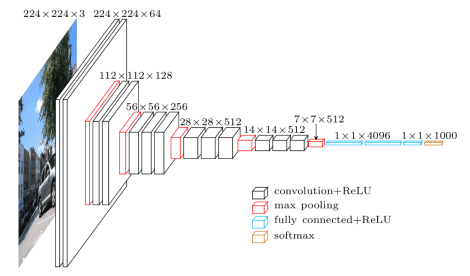

In [4]:
vgg = models.vgg19(pretrained=True).features #charge VGG-19 pré-entrainé sur ImageNet
vgg.eval() #met le modèle en mode évaluation --> désactive certains comportements spécifiques à l'entrainement (ex: dropout, batchnorm)


for param in vgg.parameters():
    param.requires_grad = False #empêche la mise à jour des poids du modèle durant l'entrainement

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 75.7MB/s]


### 1.2 Nomenclature complète de VGG19

**Bloc 1:** 0 conv1_1 | 1 relu1_1 | 2 conv1_2 | 3 relu1_2 | 4 pool1  

**Bloc 2:** 5 conv2_1 | 6 relu2_1 | 7 conv2_2 | 8 relu2_2 | 9 pool2  

**Bloc 3:** 10 conv3_1 | 11 relu3_1 | 12 conv3_2 | 13 relu3_2 | 14 conv3_3 | 15 relu3_3 | 16 conv3_4 | 17 relu3_4 | 18 pool3  

**Bloc 4:** 19 conv4_1 | 20 relu4_1 | 21 conv4_2 | 22 relu4_2 | 23 conv4_3 | 24 relu4_3 | 25 conv4_4 | 26 relu4_4 | 27 pool4  

**Bloc 5:** 28 conv5_1 | 29 relu5_1 | 30 conv5_2 | 31 relu5_2 | 32 conv5_3 | 33 relu5_3 | 34 conv5_4 | 35 relu5_4 | 36 pool5


In [5]:
# Affiche toutes les couches avec leur type et index
for i, layer in enumerate(vgg):
    print(i, layer)


0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [6]:
def get_vgg_layer_names(vgg_model):
    names = {}
    conv_count = 0
    relu_count = 0
    pool_count = 0
    block = 1

    for i, layer in enumerate(vgg_model):
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            names[i] = f"conv{block}_{conv_count}"
        elif isinstance(layer, nn.ReLU):
            names[i] = f"relu{block}_{conv_count}"  # relu suit le conv
        elif isinstance(layer, nn.MaxPool2d):
            pool_count += 1
            names[i] = f"pool{block}"
            block += 1
            conv_count = 0  # reset count pour le bloc suivant
        else:
            names[i] = str(layer)
    return names


def print_layer_names(chosen_layers, layer_names):
    print("Couches choisies :")
    for idx in chosen_layers:
        name = layer_names.get(idx, "Unknown")
        print(f"Index {idx} : {name}")


layer_names = get_vgg_layer_names(vgg)
# for i, name in layer_names.items():
#     print(i, name)


### 1.3 Extracteur de features

Les objets de classe **VGGFeatures** permettent d'extraire que certaines couches spécifiques du réseau VGG.

In [7]:
class VGGFeatures(torch.nn.Module):
    def __init__(self, vgg, layers):
        super().__init__()
        self.vgg = vgg
        self.layers = layers

    def forward(self, x):
        features = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                features[i] = x
        return features

In [8]:
# #Choix des couches à utiliser
# content_layers = [10]  # conv3_1 (c - Fig1)
# style_layers = [0, 5, 10] # jusqu'à conv3_1

# #Instancier l'extracteur
# extractor = VGGFeatures(vgg, layers=content_layers + style_layers)

## 2. Implémentation de la loss

### 2.1 Perte de contenu :

Soient $\tilde{p}$ l’image originale et $\tilde{x}$ l’image générée, et soient $P^l$ et $F^l$ leurs représentations de caractéristiques respectives à la couche $l$. On définit alors la fonction de perte de contenu comme l’erreur quadratique entre ces deux représentations :

$$
\mathcal{L}_{\text{contenu}}(\tilde{p}, \tilde{x}, l)
= \frac{1}{2} \sum_{i,j} \left( F^l_{ij} - P^l_{ij} \right)^2.
$$

La dérivée de cette fonction de perte par rapport aux activations de la couche $l$ est donnée par :

$$
\frac{\partial \mathcal{L}_{\text{contenu}}}{\partial F^l_{ij}}
=
\begin{cases}
\left( F^l - P^l \right)_{ij} & \text{si } F^l_{ij} > 0, \\
0 & \text{si } F^l_{ij} < 0.
\end{cases}
$$



In [9]:
def content_loss(F, P):
    return torch.mean((F - P) ** 2)


### 2.2 Perte de style :

**Définition de la matrice de Gram.**  
La matrice de Gram $G^l \in \mathbb{R}^{N_l \times N_l}$ est définie de telle sorte que chaque élément $G^l_{ij}$ correspond au produit scalaire entre les cartes de caractéristiques vectorisées $i$ et $j$ de la couche $l$ :

$$
G^l_{ij} = \sum_k F^l_{ik} \, F^l_{jk}.
$$



In [10]:
def gram_matrix(x):
    b, c, h, w = x.size() # b : nombre d'images dans le batch, c : nombre de canaux, h et w : hauteur et largeur des features maps,
    features = x.view(c, h * w) #aplatit les features maps en une matrice de taille (c, h*w)
    G = torch.mm(features, features.t()) #produit matriciel
    return G


Soient $\tilde{a}$ l’image de style originale et $\tilde{x}$ l’image générée, et soient $A^l$ et $G^l$ leurs représentations de style respectives à la couche $l$. La contribution de cette couche à la fonction de perte totale est définie par :

$$
E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} \left( G^l_{ij} - A^l_{ij} \right)^2.
$$

La fonction de perte de style totale est alors donnée par :

$$
\mathcal{L}_{\text{style}}(\tilde{a}, \tilde{x}) = \sum_{l=0}^{L} w_l \, E_l,
$$

où les coefficients $w_l$ pondèrent la contribution de chaque couche à la perte totale (voir ci-dessous pour les valeurs spécifiques de $w_l$ utilisées dans nos résultats).

La dérivée de $E_l$ par rapport aux activations de la couche $l$ peut être calculée analytiquement et s’écrit :

$$
\frac{\partial E_l}{\partial F^l_{ij}}
=
\begin{cases}
\displaystyle \frac{1}{N_l^2 M_l^2}
\left( (F^l)^{\top} (G^l - A^l) \right)_{ji}
& \text{si } F^l_{ij} > 0, \\
0 & \text{si } F^l_{ij} < 0.
\end{cases}
$$

In [11]:
def style_loss(gen_features, style_grams, style_layers, weights):
    loss = 0.0
    for i, l in enumerate(style_layers):
        # Gram matrix de l'image générée à la couche l
        G = gram_matrix(gen_features[l])
        A = style_grams[l]  # Gram matrix pré-calculée de l'image de style

        N = gen_features[l].size(1)   # nombre de canaux
        M = gen_features[l].size(2) * gen_features[l].size(3)  # h * w = nombre de pixels par canal

        E_l = torch.sum((G - A) ** 2) / (4 * (N ** 2) * (M ** 2))

        loss += weights[i] * E_l
    return loss


## 3. Représentation des images

### 3.0 Fonctions de chargement des images

Les fonctions suivantes permettent d'upload les images et de les convertir au  bon format.

In [12]:
data_path = os.path.join(current_dir, "data")

In [13]:
def load_image(img_name, max_size=None):
    " charge l'image et la redimensionne si besoin "

    img_path = os.path.join(data_path, img_name)
    img = Image.open(img_path).convert("RGB")

    size = img.size  # (width, height)
    if max_size:
        ratio = max_size / max(size)
        new_size = (int(size[0]*ratio), int(size[1]*ratio))
        img = img.resize(new_size, Image.LANCZOS)

    loader = transforms.ToTensor()
    img_loaded = loader(img).unsqueeze(0)
    return img_loaded

def tensor_to_image(tensor):
    img = tensor.detach().cpu().squeeze(0)          # retirer batch
    img = img.permute(1,2,0)                        # (C,H,W) -> (H,W,C)
    img = (img - img.min()) / (img.max() - img.min())  # normaliser entre 0 et 1
    return img

def plot_image(img_loaded, title):


    print("Shape du tensor :", img_loaded.shape)
    if img_loaded.shape[1] != 3:
        print("Attention : l'image n'a pas 3 canaux !")
    else:
        print("Image OK : 3 canaux (RGB)")

    plt.figure(figsize=(10,5))
    plt.imshow(tensor_to_image(img_loaded))
    plt.title(title)
    plt.show()



### 3.1 Choix de l'image de contenu

*Dans la cellule ci-dessous : choix de l'image dont on veut reconstituer le contenu + résolution souhaitée*

On va également créer à partir de cette image, l'image initiale qui sera générée progressivement par le modèle

Shape du tensor : torch.Size([1, 3, 192, 256])
Image OK : 3 canaux (RGB)


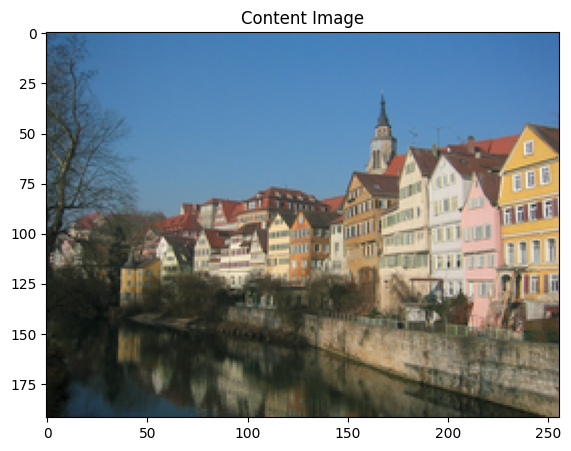

In [15]:
content_image = load_image("photo_facade.jpg", 256)

plot_image(content_image, "Content Image")


### 3.2 Reconstitution de l'image de contenu


L'objectif de cette partie est de voir comment les différentes couches du réseau capturent le contenu d'une image.

Pour ça, on fait passer notre image de contenu $\tilde{p}$ dans le réseau et on récupère les activations d'une couche $l$ qui nous intéresse.  
Ces activations sont stockées dans la matrice $P^l$ (de taille $N_l \times M_l$), où $N_l$ est le nombre de filtres et $M_l$ le nombre de positions spatiales dans cette couche.

Ensuite, on part d'une image initialement bruitée $\tilde{x}$ et on la fait passer dans le réseau jusqu'à la même couche $l$.  
On définit la **perte de contenu** entre les activations de l'image générée et celles de l'image originale par :

$$
\mathcal{L}_{\text{content}}(\tilde{p}, \tilde{x}, l) = \frac{1}{2} \sum_{i,j} \left( F^l_{ij} - P^l_{ij} \right)^2,
$$

où $F^l$ représente les activations de $\tilde{x}$ à la couche $l$.  

On met ensuite à jour l'image $\tilde{x}$ avec la **descente de gradient** pour minimiser cette perte.  
À la fin, l'image générée ressemble aux activations de l'image de contenu pour la couche $l$, ce qui nous permet de **visualiser ce que la couche a “appris” du contenu**.



#### 3.2.1 Génération d'une image bruitée

A partir de l'image de contenu, on génère une image bruitée qui va servir de point de départ pour la reconsitution de l'image couche par couche.

Shape du tensor : torch.Size([1, 3, 192, 256])
Image OK : 3 canaux (RGB)


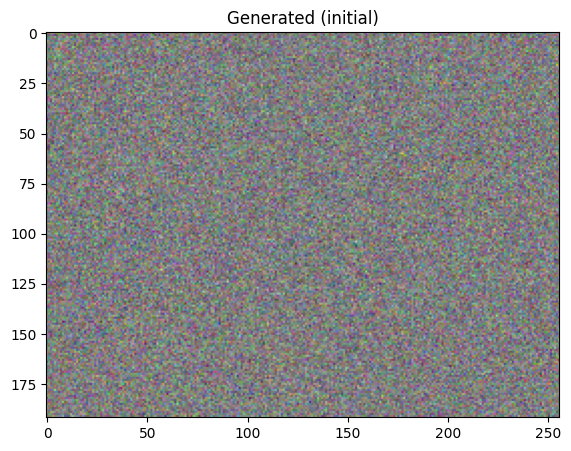

In [16]:
# génération de l'image de bruit : tenseur de la même forme que content_image
content_generated = torch.randn_like(content_image, requires_grad=True) # requires_grad = True pour que les gradients soient calculés pour cette
                                                                # -- variable durant la rétropropagation

plot_image(content_generated, "Generated (initial)")

#### 3.2.2 Choix des couches à analyser

Il s'agit ici d'instancier un objet `VGGExtractor` (cf. [section 1.3 Extracteur de features](#13-extracteur-de-features)) afin d'indiquer quelles sont les couches du réseau pour lesquelles on souhaite observer les activations.


Index des couches utiles :

**Bloc 1:** 0 conv1_1 | 1 relu1_1

**Bloc 2:** 5 conv2_1 | 6 relu2_1

**Bloc 3:** 10 conv3_1 | 11 relu3_1

**Bloc 4:** 19 conv4_1 | 20 relu4_1

**Bloc 5:** 28 conv5_1 | 29 relu5_1

In [25]:
# CHOIX COUCHES DE CONTENU

content_layers = [19]

print_layer_names(content_layers, layer_names)

Couches choisies :
Index 19 : conv4_1


In [26]:
#Instancier l'extracteur
content_extractor = VGGFeatures(vgg, layers=content_layers)

# activations (features maps) de l'image de contenu pour la couche lié à au content_extracteur
content_features = content_extractor(content_image)


#### 3.2.3 Optimisation de l'image bruitée

En fonction de la couche choisie, l'optimiseur va minimiser la loss de la sortie de la couche choisie entre l'image de contenu et l'image bruitée

In [27]:
# création d'un optimiseur qui va modifier l'image générée (bruit)
content_optimizer = torch.optim.LBFGS([content_generated])

# variable de stockage de la loss à chaque itération
last_loss = None

#calcule la loss et les gradients pour l'image générée
def content_closure():
    global last_loss

    content_optimizer.zero_grad()

    gen_features = content_extractor(content_generated)

    loss_c = content_loss(gen_features[content_layers[0]], content_features[content_layers[0]])

    loss_c.backward() # remplit content_generated.grad : gradients qui indiquent dans quelle direction chaque pixel doit être modifié

    last_loss = loss_c.item() # stockage de la loss

    return loss_c


Pour

In [23]:
# CHOIX PARAMETRES

num_steps = 500
display_steps = [1, 10, 50, 100, 200, 300, 400, 500]
loss_threshold = 1e-3  # par exemple, dès que la loss est <0.0001, on arrête

Step 1/500 | Loss: 1.014249 | Temps total: 0.42 min


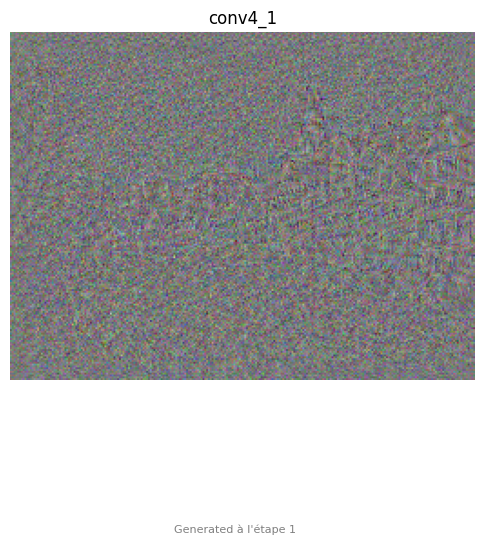

Step 2/500 | Loss: 0.794507 | Temps total: 0.85 min
Step 3/500 | Loss: 0.648063 | Temps total: 1.27 min


KeyboardInterrupt: 

In [28]:

start_total = time.time()

for i in range(num_steps):

    content_optimizer.step(content_closure) # mise à jour du tenseur content_generated

    elapsed_total = time.time() - start_total

    print(
        f"Step {i+1}/{num_steps} | "
        f"Loss: {last_loss:.6f} | "
        f"Temps total: {elapsed_total/60:.2f} min"
    )

    if (i + 1) in display_steps:
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(content_generated))
        plt.axis('off')
        plt.title(layer_names[content_layers[0]])
        plt.figtext(0.5, -0.05,f"Generated à l'étape {i+1}",ha="center", fontsize=8, color="gray")

        plt.show()

    # Stop si la loss est déjà très faible
    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(content_generated))
        plt.axis('off')
        plt.title(layer_names[content_layers[0]])
        plt.figtext(0.5, -0.05,f"Generated à l'étape {i+1}",ha="center", fontsize=8, color="gray")
        plt.show()
        break


### 3.2 Image de style

In [ ]:
# # Chargement de l'image de style
# style_path = os.path.join(current_dir, "data", "vangogh.jpg")
# style_img = Image.open(style_path).convert("RGB")

# loader = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), #redimensionnement de l'image
#     transforms.ToTensor()
# ])

# style_image = loader(style_img).unsqueeze(0)

# plt.figure(figsize=(4,4))
# plt.imshow(tensor_to_image(style_image))
# plt.title("Style Image")

# plt.show()

style_image = load_image("nuit_etoilee.jpg", 128)

plot_image(style_image, "Style Image")


## 4. Optimisation

### 4.1 Paramètres d'optimisation

.... préciser les paramètres sur lesquels on peut jouer ....

In [ ]:
alpha = 1       # poids pour le contenu
beta = 1e2

# beta = 1e2      # poids pour le style (souvent plus grand)

print("ratio contenu/style : ", alpha/beta)

content_features = extractor(content_image)

content_layers = [0]

## style
style_features = extractor(style_image)
style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

weights = [0.2, 0.2, 0.2, 0.2, 0.2]



### 4.2 Optimiseur

In [ ]:
# #création d'un optimiseur qui va modifier l'image générée (bruit)
# optimizer = torch.optim.LBFGS([generated])

# def compute_loss():
#     gen_features = extractor(generated)
#     loss_c = content_loss(
#         gen_features[content_layers[0]],
#         content_features[content_layers[0]]
#     )
#     return alpha * loss_c

# def closure():
#     optimizer.zero_grad()

#     loss = compute_loss()
#     loss.backward()

#     print(loss)

#     return loss


# #closure calcule la loss, les gradients et retourne la loss
# def closure():
#     optimizer.zero_grad() # réinitialise les gradients

#     gen_features = extractor(generated) # Passer l'image générée dans le VGG + extrait les features de l'image

#     # Content loss
#     loss_c = content_loss(gen_features[content_layers[0]], content_features[content_layers[0]])

#     # Style loss totale pondérée avec ta fonction
#     # style_loss attend : gen_features, style_grams, style_layers, weights
#     #loss_s = style_loss(gen_features, style_grams, style_layers, weights)

#     # Loss totale : content + style
#     #loss = alpha * loss_c + beta * loss_s

#     loss = alpha * loss_c

#     # Calcul des gradients
#     loss.backward()

#     return loss



In [ ]:
content_layers = [20]  # conv3_1 (c - Fig1)


#Instancier l'extracteur
content_extractor = VGGFeatures(vgg, layers=content_layers)


content_features = content_extractor(content_image)
gen_features = content_extractor(content_image)
print("Couches extraites :", gen_features.keys())


In [ ]:
# création d'un optimiseur qui va modifier l'image générée (bruit)
optimizer = torch.optim.LBFGS([generated])

last_loss = None

def closure():
    global last_loss

    optimizer.zero_grad()

    gen_features = content_extractor(generated)

    loss_c = content_loss(
        gen_features[content_layers[0]],
        content_features[content_layers[0]]
    )

    loss = alpha * loss_c
    loss.backward()

    last_loss = loss.item()  # ← on stocke la valeur scalaire ici

    return loss


In [ ]:
num_steps = 500
loss_threshold = 1e-4  # par exemple, dès que la loss est <0.0001, on arrête
start_total = time.time()

for i in range(num_steps):

    optimizer.step(closure) # mise à jour du tenseur content_generated

    elapsed_total = time.time() - start_total

    print(
        f"Step {i+1}/{num_steps} | "
        f"Loss: {last_loss:.6f} | "
        f"Temps total: {elapsed_total/60:.2f} min"
    )

    if (i + 1) in [1, num_steps]:
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()

    # Stop si la loss est déjà très faible
    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()
        break


In [ ]:
num_steps = 500
loss_threshold = 1e-4  # par exemple, dès que la loss est <0.0001, on arrête
start_total = time.time()

for i in range(num_steps):

    optimizer.step(closure)

    elapsed_total = time.time() - start_total

    print(
        f"Step {i+1}/{num_steps} | "
        f"Loss: {last_loss:.6f} | "
        f"Temps total: {elapsed_total/60:.2f} min"
    )

    if (i + 1) in [1, num_steps]:
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()

    # Stop si la loss est déjà très faible
    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()
        break
